## On CIFAR10 Color Data

#### Autoencoders 
#### Kirty Vedula

In [1]:


# Data Loading and Preprocessing
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline
import time
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

C:\Users\kpvedula\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the CIFAR data set and scale the images to a range between 0 and 1

# Load the training and test data sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

# The data set consists 3D arrays with 60K training and 10K test images with a resolution of 28 x 28

In [3]:
# Reshape the 3D arrays as matrices. In doing so, we'll reshape the 28 x 28 images into vectors of length 784

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((50000, 3072), (10000, 3072))

## Simple Autoencoder

* The encoder layer "encodes" the input image as a compressed representation in a reduced dimension. The compressed image typically looks garbled, nothing like the original image.
* The decoder layer "decodes" the encoded image back to the original dimension.

In [4]:
# input dimension = 784
size = 32
input_dim = x_train.shape[1]
encoding_dim = 3*size

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

Compression factor: 32.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                295008    
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              297984    
Total params: 592,992
Trainable params: 592,992
Non-trainable params: 0
_________________________________________________________________


### Encoder Model

We can extract the encoder model from the first layer of the autoencoder model. The reason we want to extract the encoder model is to examine what an encoded image looks like.

In [5]:
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                295008    
Total params: 295,008
Trainable params: 295,008
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Training the autoencoder - Iterate on the training data in batches of 256 in 50 epochs
# `x_train` is both the input and output, which is exactly what we want for image reconstruction.

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.6433 - val_loss: 0.6234
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.6173 - val_loss: 0.6124
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.6088 - val_loss: 0.6059
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.6031 - val_loss: 0.6016
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5990 - val_loss: 0.5980
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5963 - val_loss: 0.5959
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5941 - val_loss: 0.5948
Epoch 8/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5928 - val_loss: 0.5930
Epoch 9/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5922 - val_loss: 0.5925
Epoch

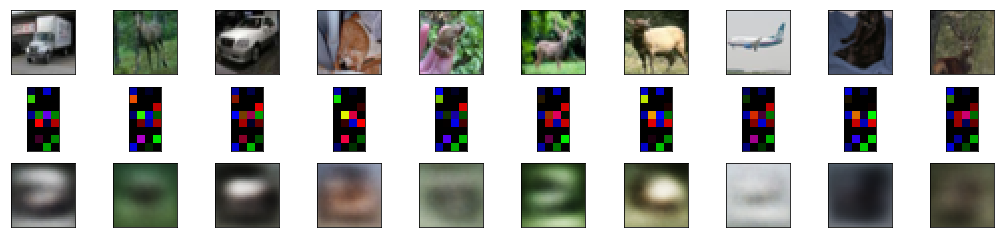

In [7]:
# To check out the encoded images and the reconstructed image quality, we randomly sample 10 test images. I really like how the encoded images look. Do they make sense? No. Are they eye candy though? Most definitely.
# However, the reconstructed images are quite lossy. You can see the digits clearly, but notice the loss in image quality.

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***

# Deep Autoencoder


Above, we used single fully-connected layers for both the encoding and decoding models. Instead, we can stack multiple fully-connected layers to make each of the encoder and decoder functions **deep**. You know because deep learning.

In this next model, we'll use 3 fully-connected layers for the encoding model with decreasing dimensions from 128 to 64 32 again. Likewise, we'll add 3 fully-connected decoder layers that reconstruct the image back to 784 dimensions. Except for the last layer, we'll use ReLU activation functions again.

In Keras, this model is painfully simple to do, so let's get started. We'll use the same training configuration: Adam + 50 epochs + batch size of 256.

In [8]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 384)               1180032   
_________________________________________________________________
dense_4 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_5 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_6 (Dense)              (None, 192)               18624     
_________________________________________________________________
dense_7 (Dense)              (None, 384)               74112     
_________________________________________________________________
dense_8 (Dense)              (None, 3072)              1182720   
Total params: 2,547,936
Trainable params: 2,547,936
Non-trainable params: 0
_________________________________________________________________


## Encoder Model

Like we did above, we can extract the encoder model from the autoencoder. The encoder model consists of the first 3 layers in the autoencoder, so let's extract them to visualize the encoded images.

In [9]:
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 384)               1180032   
_________________________________________________________________
dense_4 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_5 (Dense)              (None, 96)                18528     
Total params: 1,272,480
Trainable params: 1,272,480
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.6365 - val_loss: 0.6072
Epoch 2/50
50000/50000 [==============================] - 4s 74us/step - loss: 0.6020 - val_loss: 0.5981
Epoch 3/50
50000/50000 [==============================] - 4s 74us/step - loss: 0.5949 - val_loss: 0.5965
Epoch 4/50
50000/50000 [==============================] - 4s 74us/step - loss: 0.5904 - val_loss: 0.5897
Epoch 5/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.5879 - val_loss: 0.5875
Epoch 6/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.5857 - val_loss: 0.5850
Epoch 7/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.5839 - val_loss: 0.5843
Epoch 8/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.5827 - val_loss: 0.5828
Epoch 9/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.5818 - val_loss: 0.5837
Epoch

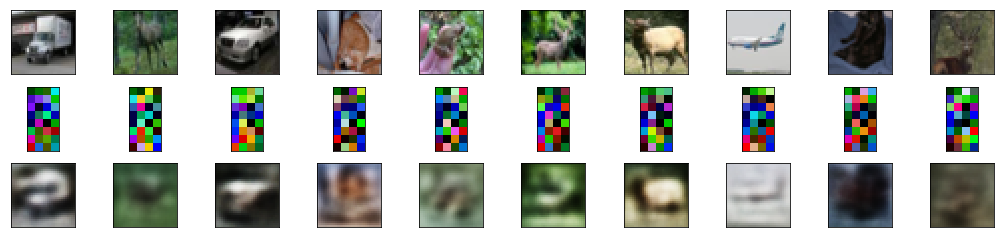

In [11]:
# The reconstructed digits look much better than those from the single-layer autoencoder. This observation aligns with the reduction in validation loss after adding multiple layers to the autoencoder.

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def train_test(data,labels):    
    from sklearn.model_selection import train_test_split 
    df_2 = pd.DataFrame(data)
    X = df_2
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
    
    return(X_train, X_test, y_train, y_test)

def kNN_classifier(x_train, y_train, x_test, y_test):
    # training a KNN classifier 
    from sklearn.neighbors import KNeighborsClassifier 
    knn = KNeighborsClassifier(n_neighbors = 10).fit(x_train, y_train) 

    # accuracy on X_test 
    accuracy = knn.score(x_test, y_test) 
    print(accuracy) 

    # creating a confusion matrix 
    knn_predictions = knn.predict(x_test)  
    cm = confusion_matrix(y_test, knn_predictions)
    print(cm)
    
    return 

def SVM_classifier(x_train, y_train, x_test, y_test):
    from sklearn.svm import SVC 
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train, y_train) 
    svm_predictions = svm_model_linear.predict(x_test) 

    # model accuracy for X_test   
    accuracy = svm_model_linear.score(x_test, y_test) 

    # creating a confusion matrix 
    cm = confusion_matrix(y_test, svm_predictions) 
    print(cm)
    print(accuracy)